<a href="https://colab.research.google.com/github/Dulu29292/Watch-list/blob/master/VAE_improved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#VAE project description

---
Team: Lucien Dupre
Anatole Bureau


Our project is the realization of a variational auto-encoder. This model is a neural network belonging to the generative model family, which can learn to generate new data resembling those on which it has been trained.

We have carried out a series of image captures in the EMC2 laboratory under the supervision of Laurent Zimmer. We created these plasmas using a pulser, varying the voltage (kV) and frequency (kHz). For each frequency and voltage we took 500 images, for a total of *6656*. Each file is labelled in its title according to its frequency and voltage, e.g. "8kv_5k".







**Image characteristics:**

* JPEG format
* 165 x 80
* Color space: RGB


**Objectives**:


1.   Generate plasma image reconstructions from original photos.
2.   Determine physical quantities from plasma images. That is, determine kHz frequency and kV voltage.

**Sources:**

Edouard Yvinec : https://deepcourse-epita.netlify.app/

Hughues Talbot :https://paperswithcode.com/method/vae

Jaan Altosaar :https://jaan.io/what-is-variational-autoencoder-vae-tutorial/

Chatgpt : https://chat.openai.com/c/a05a6830-6d7a-47aa-90d4-d3ad89624402

Tomas Beuzen : https://www.tomasbeuzen.com/deep-learning-with-pytorch/chapters/chapter5_cnns-pt1.html


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The objective here is to set up a Google drive, in order to create a connection with google colaboratory. The images are stored in a drive file.

In [2]:
root_dir = '/content/drive/My Drive/Image_JPEG'

Import of libraries required to set up VAE:


* OS: for reading and processing files
* Torch: from Pytorch to create the VAE neural network
* Matplotlib: for VAE performance analysis
* Numpy: for matrix and multidimensional array manipulation







In [3]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import re
from torch.utils.data import Dataset, DataLoader
from torch import nn, Tensor
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchsummary import summary
from torchvision.utils import make_grid
from torchvision import transforms
from PIL import Image
from torch import nn
from torch.nn import functional as F

**First step: building the DataSet**

---

**Image transformations:** Transformations, defined outside the class and passed to the instance during initialization, are used to modify images before passing them to the model. In this example, images are resized to 128x128 pixels and converted to PyTorch tensors. This pre-processing is necessary to ensure that all images have the same size and are in the format expected by the neural network.

**DataLoader creation:** Once the dataset has been instantiated, we create a dataloader. This DataLoader enables efficient iteration on the dataset in batches (here of size 32), with an option to shuffle the data (shuffle=True), which is useful for training deep learning models. However, it would be worth considering this function when we want to integrate variables such as frequency and voltage into our encoders.




In [ ]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []


        for label_dir in os.listdir(root_dir):
            label_path = os.path.join(root_dir, label_dir)
            if os.path.isdir(label_path):
                for image_file in os.listdir(label_path):
                    self.images.append(os.path.join(label_path, image_file))
                    tension, frequence = self.parse_label(label_dir)
                    self.labels.append((tension, frequence))

    def parse_label(self, label):
      label = label.lower()
      tension, frequence = label.split('_')
      tension = int(tension.replace('kv', ''))
      frequence = int(frequence.replace('khz', ''))
      return tension, frequence

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)

        label_tensor = torch.tensor(label, dtype=torch.float)
        return image, label_tensor


root_dir = '/content/drive/My Drive/Image_JPEG'
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = CustomImageDataset(root_dir=root_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


Verification section:


* Look at the total number of samples: there are 6656 images. We've got more sample, approximatively 22150 images of palsma but we've decided to continue with our first database.
If you need more sample of the plasma you can find it by sending us an email and we will transfert you by wetransfer the remaining plasma.
* Inspection of a sample: an image of a plasma labeled with a frequency and voltage is found. These are converted into Pytorch tensors for use in VAE.
* DataLoader testing: 32 per batch. Black boxes correspond to photos where there is no plasma.

Nombre total d'échantillons dans le dataset: 6656


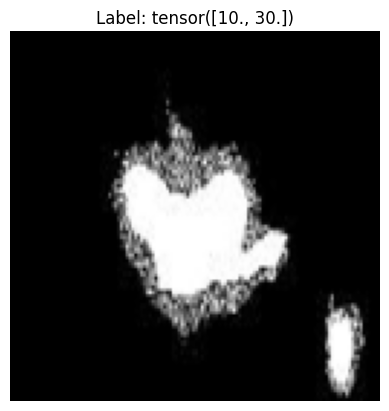

Lot 1, Taille du lot: 32
Lot 2, Taille du lot: 32
Image data type: <class 'torch.Tensor'>
     Image size: <built-in method size of Tensor object at 0x7cd15848eca0>


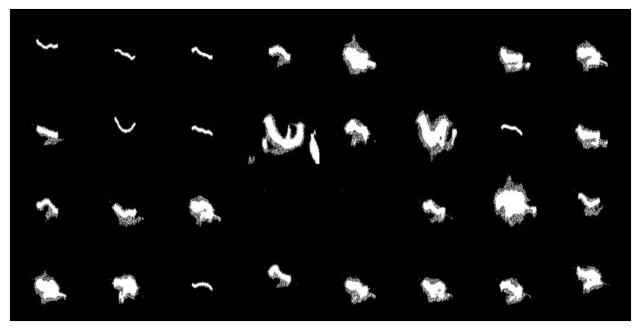

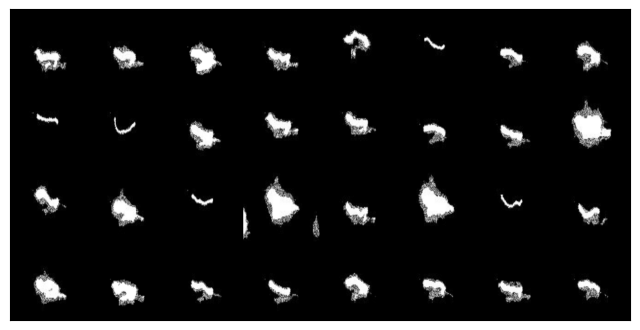

In [ ]:
# Afficher le nombre d'échantillon
print(f"Nombre total d'échantillons dans le dataset: {len(dataset)}")

# Inspecter quelques échantillons
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def inspect_sample(dataset, idx):
    image, label = dataset[idx]
    plt.imshow(image.permute(1, 2, 0))
    plt.title(f"Label: {label}")
    plt.axis('off')
    plt.show()


inspect_sample(dataset, 0)

# Teste du Data Loader
for i, (images, labels) in enumerate(dataloader):
    print(f"Lot {i+1}, Taille du lot: {images.shape[0]}")
    show_images(images)
    if i == 1:  # Affiche seulement les deux premiers lots pour tester
        break

print(f"Image data type: {type(images)}")
print(f"     Image size: {images.size}")

**Creation of the VAE**

If we note the VAE Image $I$ and the VAE *physical* $P$, we have
$$
I : x \mapsto D_I(E_I(x)) \text{ and } P : y \mapsto D_P(E_P(y))
$$
To train the image model, we have two losses: a similarity loss between $x$ and $I(x)$ and a sampling loss on $E_I(x)$. For the physical part, we'll "use" the latent of the image part. We'll have two losses: a loss of similarity between $y$ and $P(y)$, and a loss of alignment (similarity) of the latents between $E_P(y)$ and $E_I(x)$.
Concretely, if we have an example image, frequency and voltage: $(x,y_1,y_2)$, to train the physics model, we'll calculate the latents $z_x = E_I(x)$ and $z_y=E_P(y)$ then decode the physics part.

# VAEImage and VAEPhysic encoders and decoders

---
**VAEImage encoder**

The VAEImage encoder is built from successive convolutional layers, progressively reducing the spatial dimension while increasing the depth of extracted features. Here are the details:

* Starts with a 3-channel input image (RGB).

* Uses a series of convolutional layers (nn.Conv2d) with ReLU activation to capture hierarchical image features.

* After each convolution, the spatial dimension is reduced (via stride=2) and feature depth is increased.

* After spatial dimension reduction, data are flattened (nn.Flatten) in preparation for projection into latent space.

* The sequence ends with linear layers that project the data into a latent space of dimension $latent dim * 2$, allowing separation into means $(μ)$ and logarithms of variances $(log(var))$.


**VAEImage decoder**

The decoder reverses the encoding process, working backwards from latent space to the original image dimension:

* Starts with a linear layer that ascends from augmented latent space (including voltage and frequency information) to a larger dimension.

* Following ReLU reactivations, the process passes through an nn.Unflatten to recover a 3D structure suitable for transposed convolution.

* nn.ConvTranspose2d layers progressively rebuild the image's spatial dimension while reducing the feature depth.

Ends with a sigmoid activation to ensure that pixel values are within the interval $[0, 1]$.



**Physic encoder**

The purpose of the VAEPhysic encoder is to transform low-dimensional physical data into a compact representation in latent space. This transformation is performed as follows:

* Linear layers and activation: The encoder employs a series of linear layers (nn.Linear) alternated with ReLU activations (nn.ReLU()). These successive layers allow the input data to be transformed linearly, while adding non-linearity after each linear transformation, which is crucial for capturing complex relationships in the data.

* Normalization: Using nn.BatchNorm1d after the first linear layer helps stabilize and accelerate learning by normalizing activations.

* Projection into latent space: The sequence ends with a linear layer that projects the processed data into latent space, doubling the dimension to separately encode the means $(μ)$ and log-variances $(log(var))$ that define the distribution in latent space.

**Physic decoder**

The aim of the VAEPhysic decoder is to reconstruct physical data from their latent representation. It follows a reconstruction process:

* Up-dimensioning: Starting from the latent space, a sequence of linear layers and ReLU activations progressively increases the dimension of the data, reversing the reduction process operated by the encoder.

* Feature restoration: Through these transformations, the decoder attempts to reconstruct the original characteristics of the physical data from the points in latent space, seeking to recover the original shape and structure.

* Linear output: The final linear layer refines the output to match the dimensionality and scale of the input physical data, with a final ReLU activation to maintain data non-negativity if necessary.

# Focus function Loss Physic
---
This Loss is designed to integrate aspects of data reconstruction and consistency between the latent spaces of the two models: $VAEImage$ and $VAEPhysic$.


* Latent Similarity, which evaluates the similarity of the latent spaces of the two VAEs.

* We'll use the $Frobius$ norm to measure the distance between means and log variances. The aim is to promote the alignment of features learned in these latent spaces.

* The aim is to harmonize latent spaces, since the objective is to create reconstructions from images and to obtain physical quantities from images. This means capturing similar features.




In [ ]:
class VAEImage(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.latent_dim = latent_dim

        # Encodeur
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(256*8*8, 400),
            nn.ReLU(),
            nn.Linear(400, latent_dim * 2),
        )

        # Décodeur
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 400),
            nn.ReLU(),
            nn.Linear(400, 256*8*8),
            nn.ReLU(),
            nn.Unflatten(1, (256, 8, 8)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def get_latent(self, x):
        h = self.encode(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        return mu, logvar

    def forward(self, x):
        h = self.encode(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

def loss_function_image(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

class VAEPhysic(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.latent_dim = latent_dim

        # Encodeur
        self.encoder = nn.Sequential(
            nn.Linear(2, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, latent_dim * 2),
        )

        # Décodeur
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 2),
            nn.ReLU(),
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        h = self.encode(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

def loss_function_physic(recon_x, x, mu_image, logvar_image, mu_physic, logvar_physic):
    similarite_sorties = F.binary_cross_entropy(recon_x, x, reduction='sum')
    similarite_latents = (torch.norm(mu_image - mu_physic, p="fro", dim=1) ** 2).mean() + (torch.norm(logvar_image - logvar_physic, p="fro", dim=1) ** 2).mean()
    return similarite_sorties + similarite_latents

# Initialiser le modèle et l'optimiseur
model_image = VAEImage(latent_dim=2)
model_physic = VAEPhysic(latent_dim=2)
optimizer_physic = torch.optim.Adam(model_physic.parameters(), lr=1e-3)


In this section, we implement the learning and validation processes of the VAEImage auto-encoder.

* Learning process: model.train puts the model in the learning phase. Then the variables $train loss$, $total bce$ and $total kld$ are set.

Iteration on training data: data are loaded in batches from train_loader, then $loss$ and $backpropagation$ are calculated. Finally, to display the model's performance, we calculate the average $loss$.

* Validation process: to calculate model performance on the validation set.



In [ ]:
def train_image(epoch, model, train_loader, optimizer):
    model.train()
    train_loss = 0
    total_bce = 0
    total_kld = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function_image(recon_batch, data, mu, logvar)
        loss.backward()

        train_loss += loss.item()
        optimizer.step()

    average_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch: {epoch}, Average loss: {average_loss:.4f}")

def validate_image(epoch, model, val_loader):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(val_loader):
            data = data.to(device)

            recon_batch, mu, logvar = model(data)
            loss = loss_function_image(recon_batch, data, mu, logvar)
            val_loss += loss.item()

    average_loss = val_loss / len(val_loader.dataset)
    print(f"Validation Epoch: {epoch}, Average loss: {average_loss:.4f}")

# Configuration du device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_image = model_image.to(device)
optimizer_image = torch.optim.Adam(model_image.parameters(), lr=1e-3)

# Division en ensembles d'entraînement et de validation
train_indices, val_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
train_loader = DataLoader(dataset, batch_size=32, sampler=SubsetRandomSampler(train_indices))
val_loader = DataLoader(dataset, batch_size=32, sampler=SubsetRandomSampler(val_indices))

# Boucle d'entraînement et de validation
epochs = 10
for epoch in range(1, epochs + 1):
    train_image(epoch, model_image, train_loader, optimizer_image)
    validate_image(epoch, model_image, val_loader)

Epoch: 1, Average loss: 53424.0447
Validation Epoch: 1, Average loss: 1092.3396
Epoch: 2, Average loss: 4094.2178
Validation Epoch: 2, Average loss: 1089.9010
Epoch: 3, Average loss: 3311.9792
Validation Epoch: 3, Average loss: 590.9777
Epoch: 4, Average loss: 2040.3728
Validation Epoch: 4, Average loss: 522.8916
Epoch: 5, Average loss: 1893.0139
Validation Epoch: 5, Average loss: 504.2430
Epoch: 6, Average loss: 1848.5655
Validation Epoch: 6, Average loss: 490.4813
Epoch: 7, Average loss: 1812.3977
Validation Epoch: 7, Average loss: 487.1226
Epoch: 8, Average loss: 1794.4197
Validation Epoch: 8, Average loss: 482.2851
Epoch: 9, Average loss: 1778.3068
Validation Epoch: 9, Average loss: 485.9353
Epoch: 10, Average loss: 1766.9980
Validation Epoch: 10, Average loss: 476.6247


Visualisation de l'espace latent du $VAEImage$

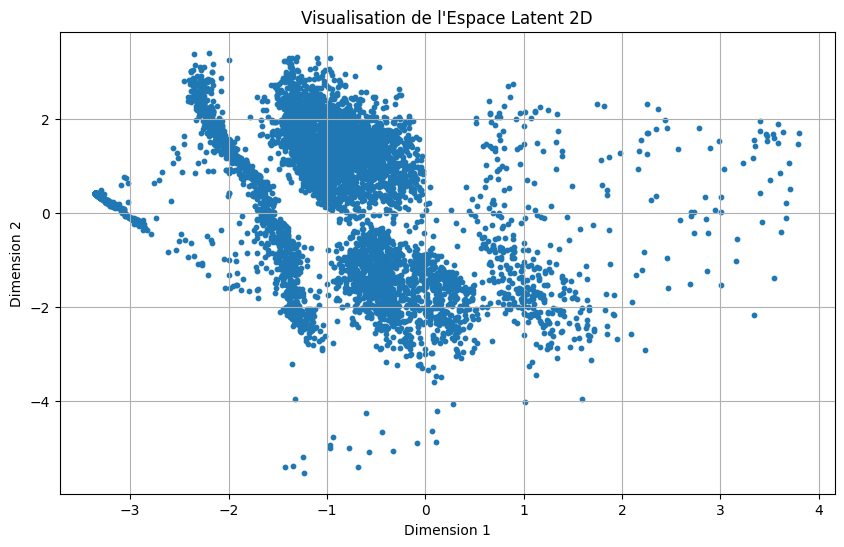

In [ ]:
def visualize_latent_space(model, dataloader, device):
    model.eval()
    mus = []

    with torch.no_grad():
        for data, _ in dataloader:
            data = data.to(device)
            mu, _ = model.get_latent(data)
            mus.append(mu.cpu())

    mus = torch.cat(mus, dim=0)
    plt.figure(figsize=(10, 6))
    plt.scatter(mus[:, 0].numpy(), mus[:, 1].numpy(), s=10)
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('Visualisation de l\'Espace Latent 2D')
    plt.grid(True)
    plt.show()


visualize_latent_space(model_image, dataloader, device)


# Training Physic model
---
We're here to train and validate a neural network model for Physic data. However, compared with the last training code, we're going to integrate latent information from our VAEImage.

* This operation is enabled by model_image.get_latent(data), which extracts the vectors $μ$ and $log(var)$.

* Then, to obtain the μ and log(var) reconstruction of the Physic model, we'll use $model(data)$.


In [ ]:
def train_physic(epoch, model_physic, model_image, train_loader, optimizer_physic):
    model_physic.train()
    model_image.eval()
    train_loss = 0

    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            _, mu_image, _ = model_image(data)

        optimizer_physic.zero_grad()
        output_physic, mu_physic, _ = model_physic(labels)

        loss_similarity = torch.nn.functional.mse_loss(output_physic, labels)
        loss_alignment = torch.nn.functional.mse_loss(mu_physic, mu_image)

        loss = loss_similarity + loss_alignment
        loss.backward()

        train_loss += loss.item()
        optimizer_physic.step()

    average_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch: {epoch}, Average loss: {average_loss:.4f}")

def validate_physic(epoch, model_physic, model_image, val_loader):
    model_physic.eval()
    model_image.eval()
    val_loss = 0

    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(val_loader):
            data = data.to(device)
            labels = labels.to(device)

            _, mu_image, _ = model_image(data)
            recon_batch, mu_physic, _ = model_physic(labels)

            loss_similarity = torch.nn.functional.mse_loss(recon_batch, labels)
            loss_alignment = torch.nn.functional.mse_loss(mu_physic, mu_image)

            loss = loss_similarity + loss_alignment
            val_loss += loss.item()

    average_loss = val_loss / len(val_loader.dataset)
    print(f"Validation Epoch: {epoch}, Average loss: {average_loss:.4f}")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


model_physic = model_physic.to(device)
model_image = model_image.to(device)

optimizer_physic = torch.optim.Adam(model_physic.parameters(), lr=1e-3)


train_indices, val_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
train_loader = DataLoader(dataset, batch_size=32, sampler=SubsetRandomSampler(train_indices))
val_loader = DataLoader(dataset, batch_size=32, sampler=SubsetRandomSampler(val_indices))

epochs = 10
for epoch in range(1, epochs + 1):
    train_physic(epoch, model_physic, model_image, train_loader, optimizer_physic)
    validate_physic(epoch, model_physic, model_image, val_loader)


Epoch: 1, Average loss: 2.7328
Validation Epoch: 1, Average loss: 0.7479
Epoch: 2, Average loss: 2.7306
Validation Epoch: 2, Average loss: 0.7463
Epoch: 3, Average loss: 2.5777
Validation Epoch: 3, Average loss: 0.5337
Epoch: 4, Average loss: 1.8825
Validation Epoch: 4, Average loss: 0.5245
Epoch: 5, Average loss: 1.8567
Validation Epoch: 5, Average loss: 0.5192
Epoch: 6, Average loss: 1.8429
Validation Epoch: 6, Average loss: 0.5170
Epoch: 7, Average loss: 1.8378
Validation Epoch: 7, Average loss: 0.5167
Epoch: 8, Average loss: 1.8367
Validation Epoch: 8, Average loss: 0.5163
Epoch: 9, Average loss: 1.8349
Validation Epoch: 9, Average loss: 0.5164
Epoch: 10, Average loss: 1.8346
Validation Epoch: 10, Average loss: 0.5211


In [ ]:
def visualize_latent_spaces(model_image, model_physic, dataloader, device):
    model_image.eval()
    model_physic.eval()
    mus_image = []
    mus_physic = []

    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.to(device), labels.to(device)

            _, mu_image, _ = model_image(data)
            _, mu_physic, _ = model_physic(labels)

            mus_image.append(mu_image.cpu().numpy())
            mus_physic.append(mu_physic.cpu().numpy())

    mus_image = np.concatenate(mus_image, axis=0)
    mus_physic = np.concatenate(mus_physic, axis=0)

    plt.figure(figsize=(10, 6))
    plt.scatter(mus_image[:, 0], mus_image[:, 1], s=10, c='red', label='Image Latent Space')
    plt.scatter(mus_physic[:, 0], mus_physic[:, 1], s=10, c='blue', label='Physic Latent Space')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('Superposition des Espaces Latents')
    plt.legend()
    plt.grid(True)
    plt.show()


visualize_latent_spaces(model_image, model_physic, val_loader, device)


NameError: name 'model_image' is not defined

We can see the layering of the two latent space. It seems there is an error becaue the Image latent space doesn't have the same points quantity than the one above. For the Physic points it is logical that there is only 13 points. Effectively all our images that feed our VAE are divided into 13 different files with different Voltage and Frequency.

In [ ]:
#def train_physic(epoch, model, model_image, train_loader, optimizer):
    #model.train()
    #model_image.eval()
    #train_loss = 0

    #for batch_idx, (data, labels) in enumerate(train_loader):
        #data = data.to(device)
        #labels = labels.to(device)
        #with torch.no_grad():
            #mu_image, logvar_image=model_image.get_latent(data)


        #optimizer.zero_grad()
        #recon_batch, mu_physic, logvar_physic = model(data)
        #loss = loss_function_physic(recon_batch, labels, mu_image, logvar_image, mu_physic, logvar_physic)
        #loss.backward()

        #train_loss += loss.item()
        #optimizer.step()

    #average_loss = train_loss / len(train_loader.dataset)
    #print(f"Epoch: {epoch}, Average loss: {average_loss:.4f}")

def train_physic(epoch, model_physic, model_image, train_loader, optimizer_physic):
    model_physic.train()
    model_image.eval()
    train_loss = 0

    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)

        with torch.no_grad():

            _, mu_image, _ = model_image(data)

        optimizer_physic.zero_grad()

        output_physic, mu_physic, _ = model_physic(labels)


        loss_similarity = F.mse_loss(output_physic, labels)
        loss_alignment = F.mse_loss(mu_physic, mu_image)

        loss = loss_similarity + loss_alignment
        loss.backward()

        train_loss += loss.item()
        optimizer_physic.step()

    average_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch: {epoch}, Average loss: {average_loss:.4f}")

def validate_physic(epoch, model, val_loader):
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(val_loader):
            data = data.to(device)
            labels = labels.to(device)
            with torch.no_grad():
                mu_image, logvar_image=model_image.get_latent(data)

            recon_batch, mu_physic, logvar_physic = model(data, tension, frequence)
            loss = loss_function_physic(recon_batch, labels, mu_image, logvar_image, mu_physic, logvar_physic)
            val_loss += loss.item()

    average_loss = val_loss / len(val_loader.dataset)
    print(f"Validation Epoch: {epoch}, Average loss: {average_loss:.4f}")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_physic = model_physic.to(device)
optimizer_physic = torch.optim.Adam(model_physic.parameters(), lr=1e-3)


train_indices, val_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)
train_loader = DataLoader(dataset, batch_size=32, sampler=SubsetRandomSampler(train_indices))
val_loader = DataLoader(dataset, batch_size=32, sampler=SubsetRandomSampler(val_indices))


epochs = 10
for epoch in range(1, epochs + 1):
    train_physic(epoch, model_physic,model_image, train_loader, optimizer_physic)
    validate_physic(epoch, model_physic, val_loader)

Epoch: 1, Average loss: 2.7414


NameError: name 'tension' is not defined

#The aim of creating these classes :
---
The aim is to facilitate inter-domain transfer in order to encode information, whether image or physical, and then decode it in a different decoder. This is necessary in our project to be able to both determine an image from a voltage and determine a voltage and frequency from an image.

**We've stopped here**.









In [ ]:
class Physic2Image(nn.Module):#Initialise un modèle qui va combiner l'encodeur physic et le décodeur image.
    def __init__(self, vae_image: VAEImage, vae_physic: VAEPhysic)->None:
      super().__init__()
      self.encoder = vae_physic.encoder
      self.decoder = vae_image.decoder

    def reparameterize(self, mu:Tensor, logvar:Tensor)->Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, x:Tensor)->Tensor:
        h = self.encode(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        z = self.reparameterize(mu, logvar)
        return self.decode(z)

class Image2Physic(nn.Module):#inverse le processus Physic2Image utilisant l'encodeur VAE_image et le décodeur VAE_Physic
  def __init__(self, vae_image: VAEimage, vae_physic: VAEPhysic)->None:
    super().__init__()
    self.encoder = vae_image.encoder
    self.decoder = vae_physic.decoder

  def reparameterize(self, mu:Tensor, logvar:Tensor)->Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

  def forward(self, x:Tensor)->Tensor:
        h = self.encode(x)
        mu, logvar = torch.chunk(h, 2, dim=1)
        z = self.reparameterize(mu, logvar)
        return self.decode(z)


NameError: name 'VAEimage' is not defined

---

In [ ]:
!pip install torchsummary


SyntaxError: incomplete input (<ipython-input-27-1c8c0626a7f6>, line 6)

In [ ]:
model = VAE(latent_dim=20)
summary(model.cpu(), (3, 128, 128))

TypeError: VAE.forward() missing 2 required positional arguments: 'tension' and 'frequence'

In [ ]:
def save_latent_space(model, dataloader):
    model.eval()
    mus = []
    logvars = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            labels = labels.to(device)
            tension, frequence = labels[:, 0], labels[:, 1]
            _, mu, logvar = model(data, tension, frequence)
            mus.append(mu)
            logvars.append(logvar)

    mus = torch.cat(mus, dim=0)
    logvars = torch.cat(logvars, dim=0)
    torch.save(mus, '/content/drive/My Drive/mu.pt')
    torch.save(logvars, '/content/drive/My Drive/logvar.pt')


ValueError: too many values to unpack (expected 2)

Visualisation de $mu$ et de la $variance$ pour l'optimisation du modèle

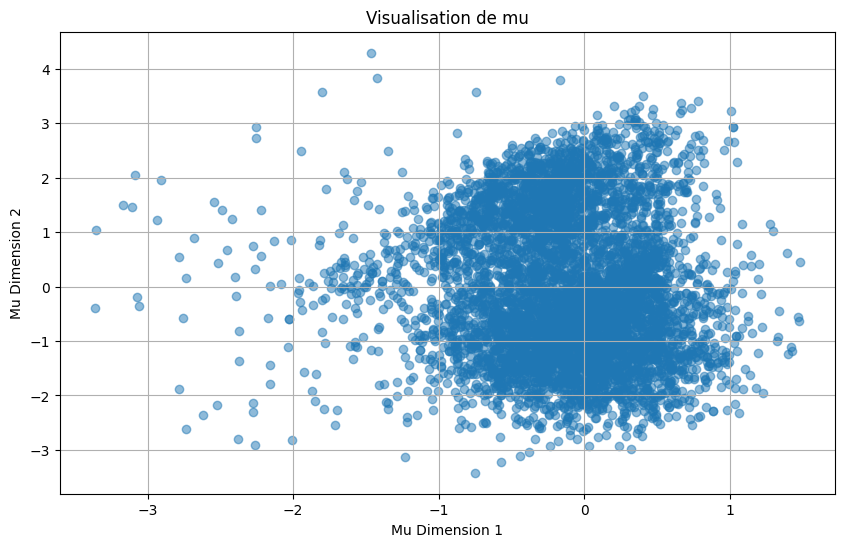

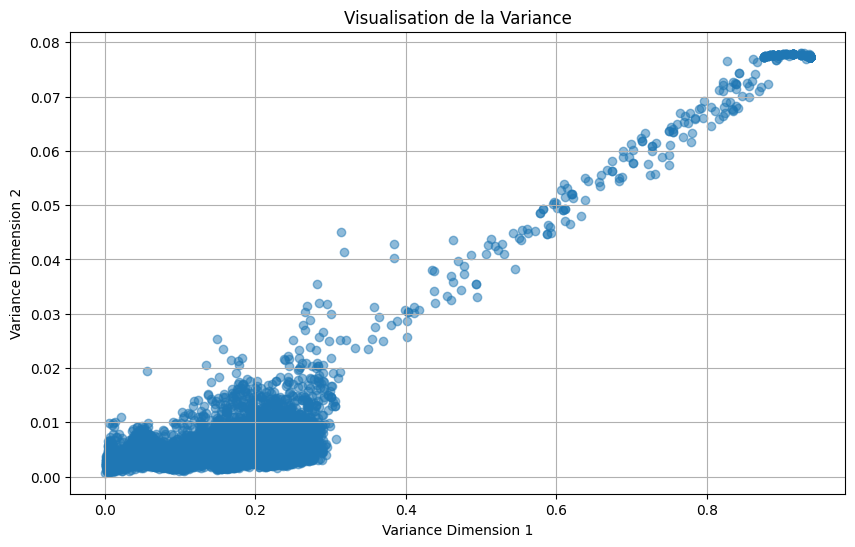

In [ ]:
# Chemin vers vos fichiers sauvegardés
mu_path = '/content/drive/My Drive/Colab_Notebooks/mu.pt'
logvar_path = '/content/drive/My Drive/Colab_Notebooks/logvar.pt'

# Charger les données
mu = torch.load(mu_path)
logvar = torch.load(logvar_path)

# Convertir en numpy pour la visualisation
mu = mu.numpy()
logvar = logvar.numpy()

# Visualiser mu
plt.figure(figsize=(10, 6))
plt.scatter(mu[:, 0], mu[:, 1], alpha=0.5)
plt.title('Visualisation de mu')
plt.xlabel('Mu Dimension 1')
plt.ylabel('Mu Dimension 2')
plt.grid(True)
plt.show()

# Visualiser logvar
# Puisque logvar peut avoir des valeurs négatives et est dans un espace logarithmique,
# nous pouvons prendre l'exponentielle pour visualiser la variance elle-même
variance = np.exp(logvar)

plt.figure(figsize=(10, 6))
plt.scatter(variance[:, 0], variance[:, 1], alpha=0.5)
plt.title('Visualisation de la Variance')
plt.xlabel('Variance Dimension 1')
plt.ylabel('Variance Dimension 2')
plt.grid(True)
plt.show()

In [ ]:

# Test du modèle et visualisation des reconstructions
dataiter = iter(dataloader)
images, _ = next(dataiter)

with torch.no_grad():
    # Assurez-vous que les dimensions sont correctes
    tension = torch.zeros(images.size(0), 1).to(device)  # images.size(0) donne le nombre d'échantillons dans le batch
    frequence = torch.zeros(images.size(0), 1).to(device)

    # Appelez la méthode forward en fournissant les valeurs nécessaires
    reconstructions, _, _ = model(images, tension, frequence)


# Définissez ici le nombre d'images que vous souhaitez afficher
number_of_images = 5  # Ajustez à 5 comme indiqué

# Créez une figure avec une grille de subplots
fig, axs = plt.subplots(2, number_of_images, figsize=(10, 4))


# Réglage de l'espacement pour éviter le chevauchement des titres et des images
plt.subplots_adjust(hspace=0.5, top=0.85)

# Affichage des images originales et des reconstructions
for i in range(number_of_images):
    # Images originales
    axs[0, i].imshow(np.transpose(images[i].numpy(), (1, 2, 0)), cmap='gray')
    axs[0, i].axis('off')

    # Images reconstruites
    axs[1, i].imshow(np.transpose(reconstructions[i].numpy(), (1, 2, 0)), cmap='gray')
    axs[1, i].axis('off')

plt.show()


RuntimeError: Tensors must have same number of dimensions: got 2 and 3

Deuxième VAE (physique) au lieu Loss et KL sur la latent il va avoir une loss de similarité avec la VAE

NameError: name 'device' is not defined

**Ancienne visualisation de l'espace $latent$ **





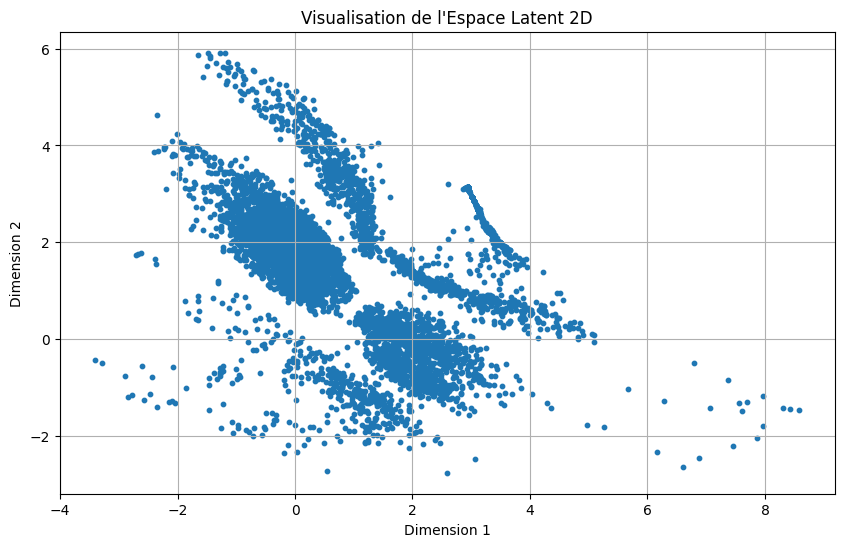

In [ ]:

# Fonction pour visualiser l'espace latent
def visualize_latent_space(model, dataloader):
    model.eval()
    mus = []

    with torch.no_grad():
        for data, _ in dataloader:
            data = data
            mu, logvar = model.encode(data)
            mus.append(mu.numpy())

    mus = np.concatenate(mus, axis=0)
    plt.figure(figsize=(10, 6))
    plt.scatter(mus[:, 0], mus[:, 1], s=10)  # Tracer les moyennes mu
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('Visualisation de l\'Espace Latent 2D')
    plt.grid(True)
    plt.show()

#visualisation l'espace latent :
visualize_latent_space(model, dataloader)




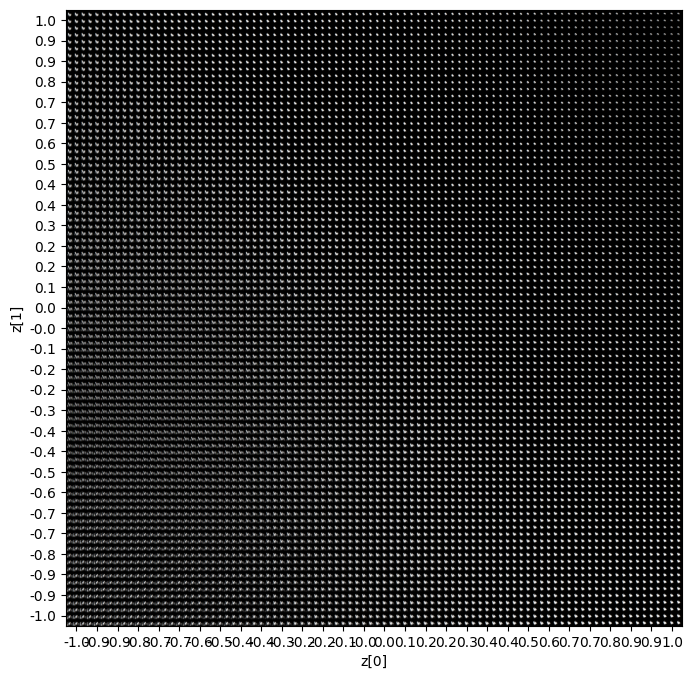

In [ ]:
@torch.no_grad()
def plot_latent_space(vae, n=30, figsize=(8,8)):
    image_size = 128  # Ajustez selon la taille réelle de vos images générées par le VAE
    scale = 1.0
    # Initialiser figure avec 3 canaux pour RGB
    figure = np.zeros((image_size * n, image_size * n, 3))

    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    vae.eval()  # Assurer que le VAE est en mode évaluation
    device = next(vae.parameters()).device  # Utiliser le même appareil que le modèle

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], device=device).float()
            x_decoded = vae.decode(z_sample)
            image = x_decoded.view(image_size, image_size, 3).detach().cpu().numpy()
            # Copier l'image décodée dans la figure à la position correspondante
            figure[
                i * image_size: (i + 1) * image_size,
                j * image_size: (j + 1) * image_size,
                :
            ] = image

    plt.figure(figsize=figsize)
    start_range = image_size // 2
    end_range = (n * image_size) + start_range
    pixel_range = np.arange(start_range, end_range, image_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure)
    plt.show()

# Exemple d'appel
plot_latent_space(model)

Pour intégrer une phase de validation, vous pouvez diviser votre dataset en ensembles d'entraînement et de validation. Utilisez une partie des données (par exemple, 80% pour l'entraînement et 20% pour la validation) pour évaluer la performance du modèle sur des données non vues pendant l'entraînement.

In [ ]:
# Suggestion
from sklearn.model_selection import train_test_split

# Supposons que `dataset` est votre instance CustomImageDataset
train_indices, val_indices = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)

train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size=32, sampler=train_sampler)
val_loader = DataLoader(dataset, batch_size=32, sampler=val_sampler)

Pour déterminer les grandeurs physiques (fréquence et tension) à partir des images, vous pouvez ajouter une tête de classification à l'encodeur ou entraîner un modèle séparé sur les caractéristiques extraites par l'encodeur.

In [ ]:
class VAEWithClassifier(VAE):
    def __init__(self, latent_dim=20, num_classes=10):  # num_classes est un exemple
        super(VAEWithClassifier, self).__init__(latent_dim=latent_dim)
        self.classifier = nn.Linear(latent_dim, num_classes)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        class_pred = self.classifier(mu)  # Classifie sur la base de mu
        return recon, mu, logvar, class_pred


In [ ]:
#Aussi faire le graph avec couleur différente selon region